In [1]:
# Import required libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import SGD
%matplotlib inline

2024-02-13 17:57:49.453827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Loading data

## 1.1 Read columns

In [2]:
# Read column names
columns = pd.read_csv("data/NSL_KDD/kddcup.names", names=['names'])
columns

,names
0,duration
1,protocol_type
2,service
3,flag
4,src_bytes
5,dst_bytes
6,land
7,wrong_fragment
8,urgent
9,hot


In [3]:
columns.describe()

,names
count,43
unique,43
top,duration
freq,1


In [4]:
columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   names   43 non-null     object
dtypes: object(1)
memory usage: 472.0+ bytes


## 1.2 Read attacks

In [3]:
# Read attack names
attacks = pd.read_csv("data/NSL_KDD/attack.types", sep=" ", names=["class", "attack"])
attacks

,class,attack
0,back,dos
1,land,dos
2,neptune,dos
3,pod,dos
4,smurf,dos
5,teardrop,dos
6,processtable,dos
7,udpstorm,dos
8,mailbomb,dos
9,apache2,dos


## 1.3 Load dataset

### 1.3.1 Load csv files

In [4]:
data_train = pd.read_csv("data/NSL_KDD/KDDTrain+.txt", names=columns["names"])
data_test = pd.read_csv("data/NSL_KDD/KDDTest+.txt", names=columns["names"])

In [5]:
data_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,target
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [6]:
data_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,target
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


### 1.3.2 Update columns

In [7]:
def update_columns(df, attacks):
    """Replace target column with attack_type column and add connection_type column"""
    attacks = attacks.set_index("class").T.to_dict("index")
    df = df.drop("target", axis=1)
    df["attack_type"] = df["class"].map(attacks["attack"])
    df['connection_type'] = np.where(df['attack_type']=='normal', 'normal', 'attack')
    return df

In [8]:
data_train = update_columns(data_train, attacks)
data_train.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,attack_type,connection_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,normal,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos,attack
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,normal,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,normal,normal
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,dos,attack
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos,attack
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos,attack
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos,attack
9,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos,attack


In [9]:
data_test = update_columns(data_test, attacks)
data_test.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,attack_type,connection_type
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.00,0.00,1.00,1.00,neptune,dos,attack
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.00,0.00,1.00,1.00,neptune,dos,attack
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.00,0.00,0.00,0.00,normal,normal,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.00,0.00,0.00,0.00,saint,probe,attack
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.00,0.00,0.83,0.71,mscan,probe,attack
5,0,tcp,http,SF,267,14515,0,0,0,0,...,0.00,0.01,0.03,0.01,0.00,0.00,0.00,normal,normal,normal
6,0,tcp,smtp,SF,1022,387,0,0,0,0,...,0.72,0.00,0.00,0.00,0.00,0.72,0.04,normal,normal,normal
7,0,tcp,telnet,SF,129,174,0,0,0,0,...,0.00,0.00,0.00,0.01,0.01,0.02,0.02,guess_passwd,r2l,attack
8,0,tcp,http,SF,327,467,0,0,0,0,...,0.00,0.01,0.03,0.00,0.00,0.00,0.00,normal,normal,normal
9,0,tcp,ftp,SF,26,157,0,0,0,0,...,0.08,0.02,0.00,0.00,0.00,0.00,0.00,guess_passwd,r2l,attack


### 1.3.3 General info on dataset

In [12]:
data_train.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [13]:
# Shape of training dataset
data_train.shape

(125973, 44)

In [14]:
# Find missing values in training dataset
data_train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [15]:
data_test.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [16]:
# Shape of testing dataset
data_test.shape

(22544, 44)

In [17]:
# Find missing values in testing dataset
data_test.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

# 2. Data visualisation

## 2.1 Visualisation of continuous data

In [10]:
def get_columns(df):
    data = []
    columns = df.select_dtypes('object').columns.to_list()
    for column in columns:
        data.append(column)
        data.append(df[column].value_counts().to_dict())
    return data

In [11]:
# Draw bar plots of continuous data statistics
def bar_plots(data, title):
    fig, ax = plt.subplots(nrows=len(data)//2,
                           ncols=1,
                           figsize=(10,25))
    for i in range(0,len(data),2):
        ax[i//2].grid(which='Major', axis='both')
        ax[i//2].bar(data[i+1].keys(), data[i+1].values())
        ax[i//2].set(title=f"{data[i]} distribution",
                  xlabel=f"{data[i]}",
                  ylabel="Frequency")
        if data[i] in ['service', 'class'] or len(data[i+1]) > 10:
            ax[i//2].tick_params(axis='x', labelrotation=90)
    fig.suptitle(f"{title} data distribution", fontsize=16, fontweight="bold")
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

### 2.1.1 Training data visualisation

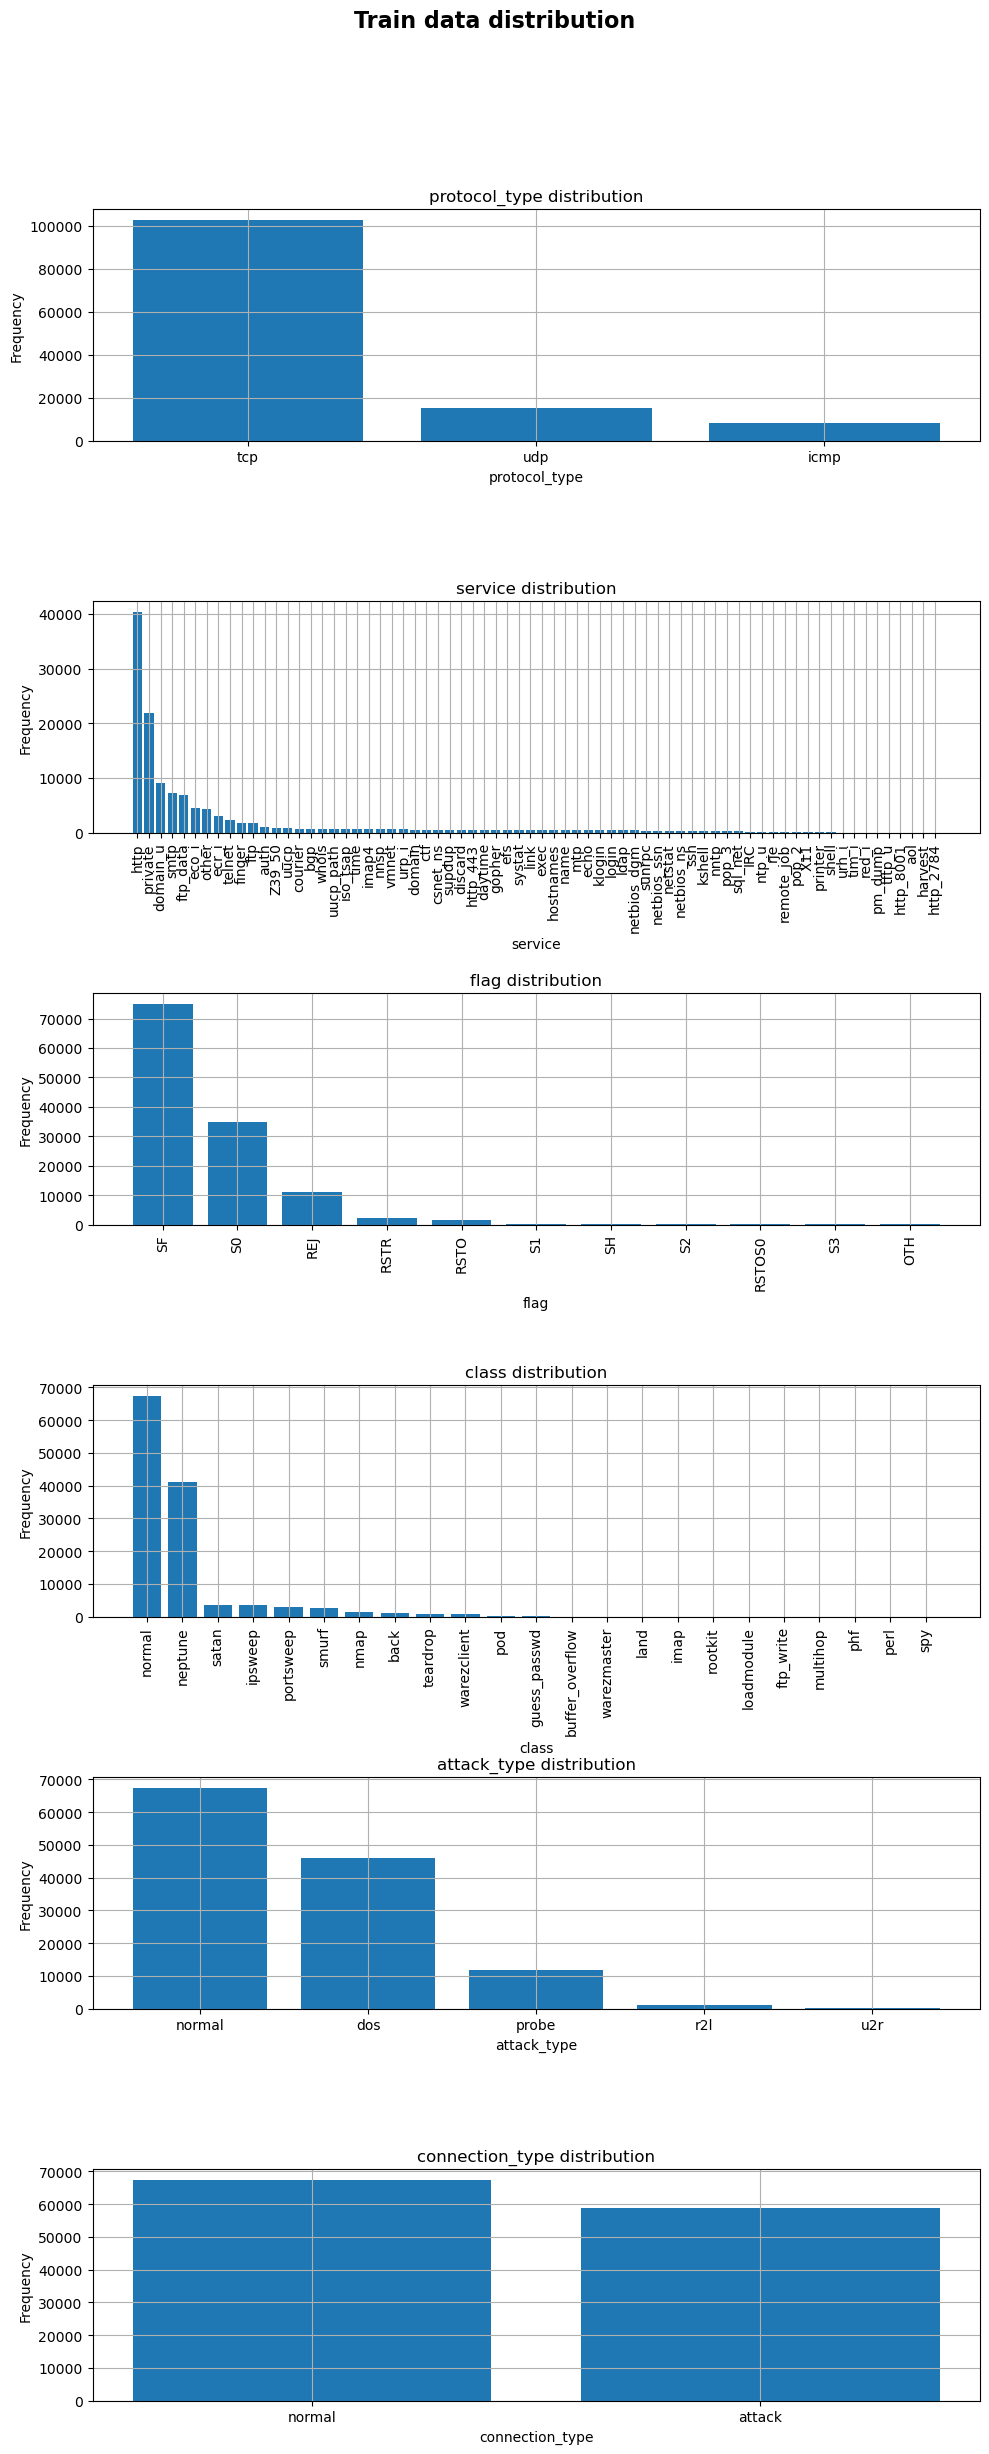

In [12]:
# Plot train data
bar_plots(get_columns(data_train), "Train")

### 2.1.2 Testing data visualisation

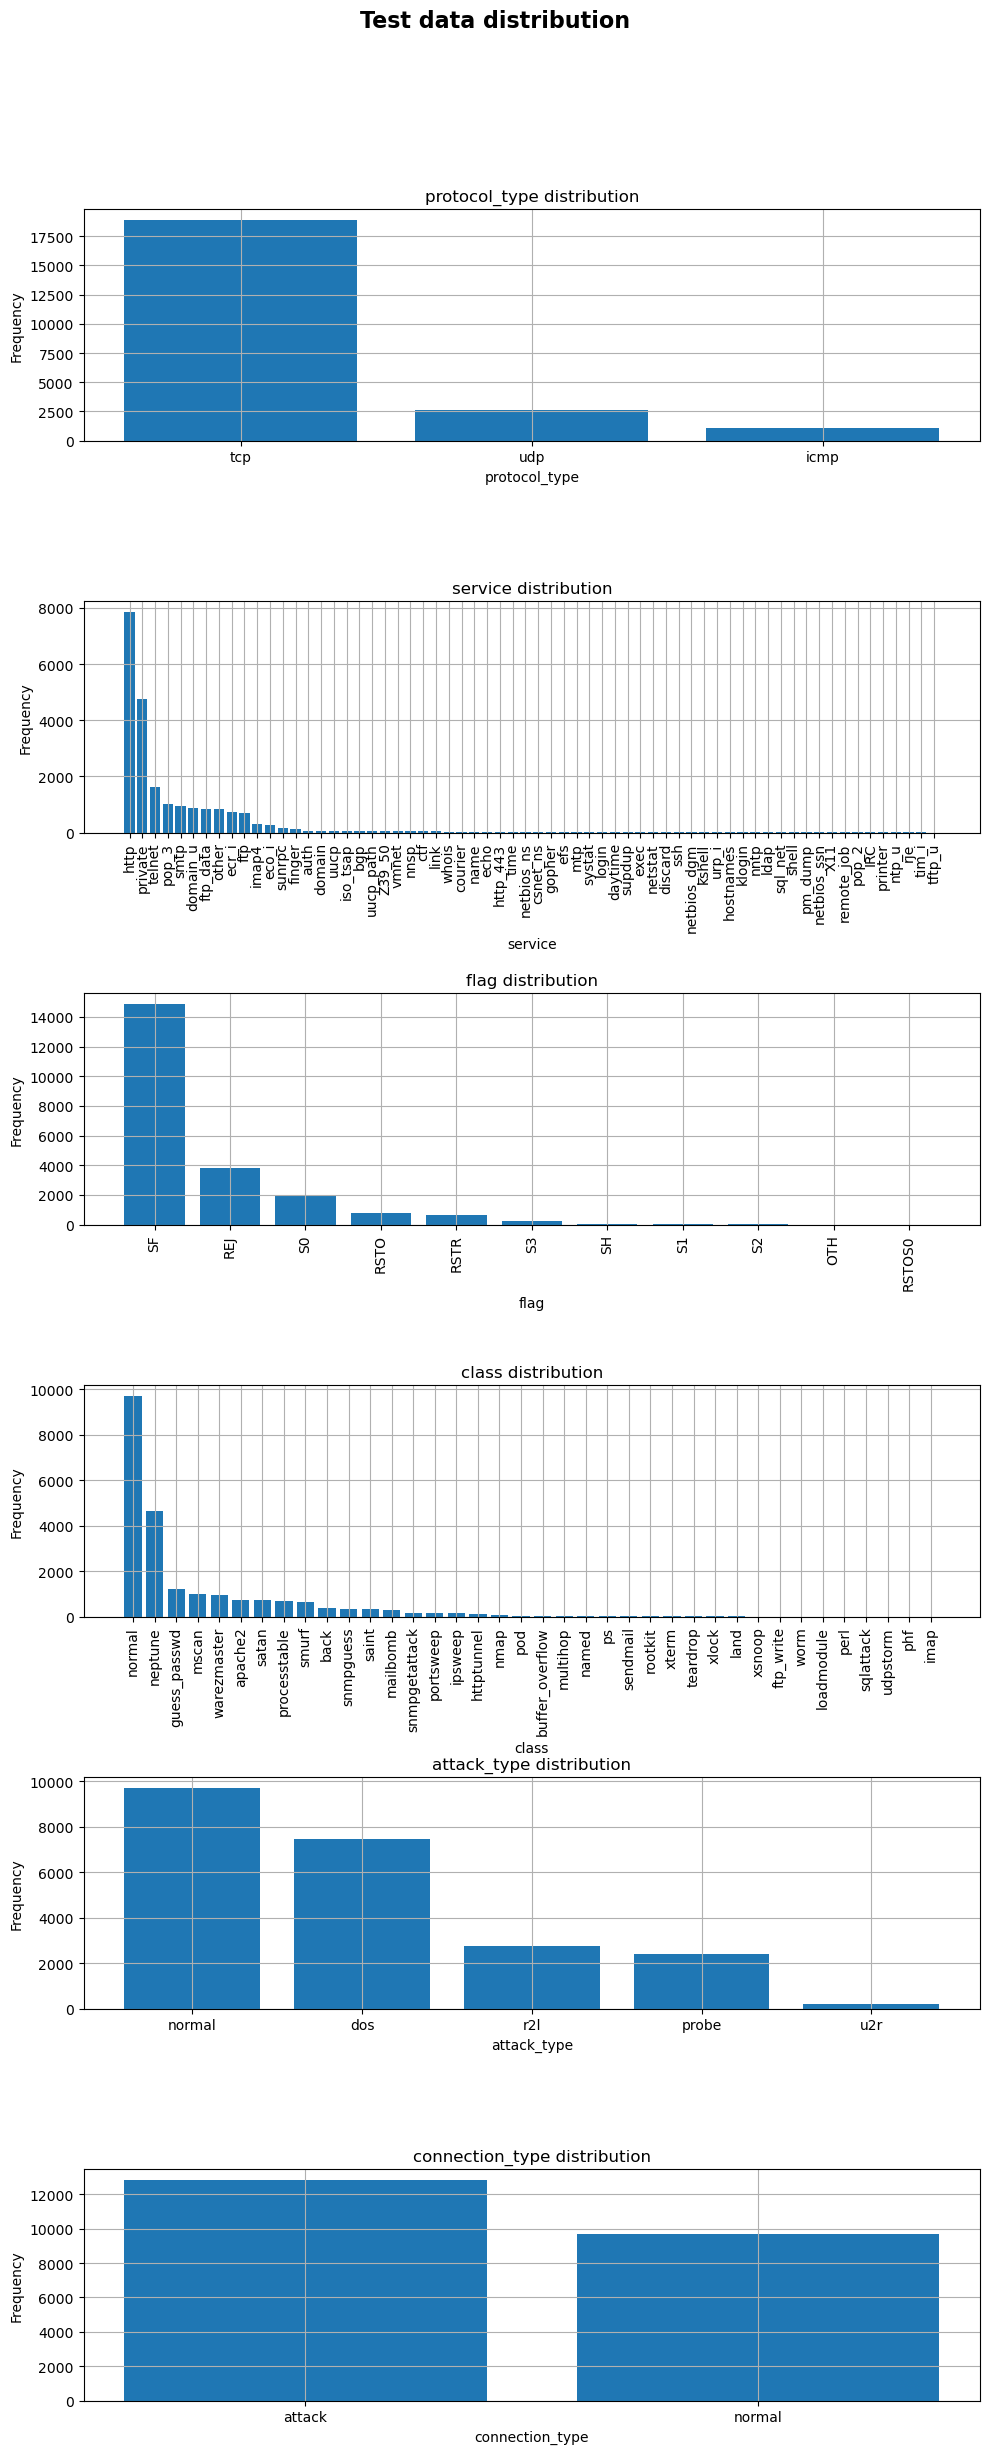

In [13]:
# Plot test data
bar_plots(get_columns(data_test), "Test")

## 2.2 Data distribution per protocol

In [12]:
def get_distribution(df, column):
    data = []
    protocols = df['protocol_type'].unique()
    for protocol in protocols:
        new_df = df.loc[df['protocol_type'] == protocol]
        data.append(protocol)
        data.append(new_df[column].value_counts().to_dict())
    return data

### 2.2.1 Connection type distribution per network protocol

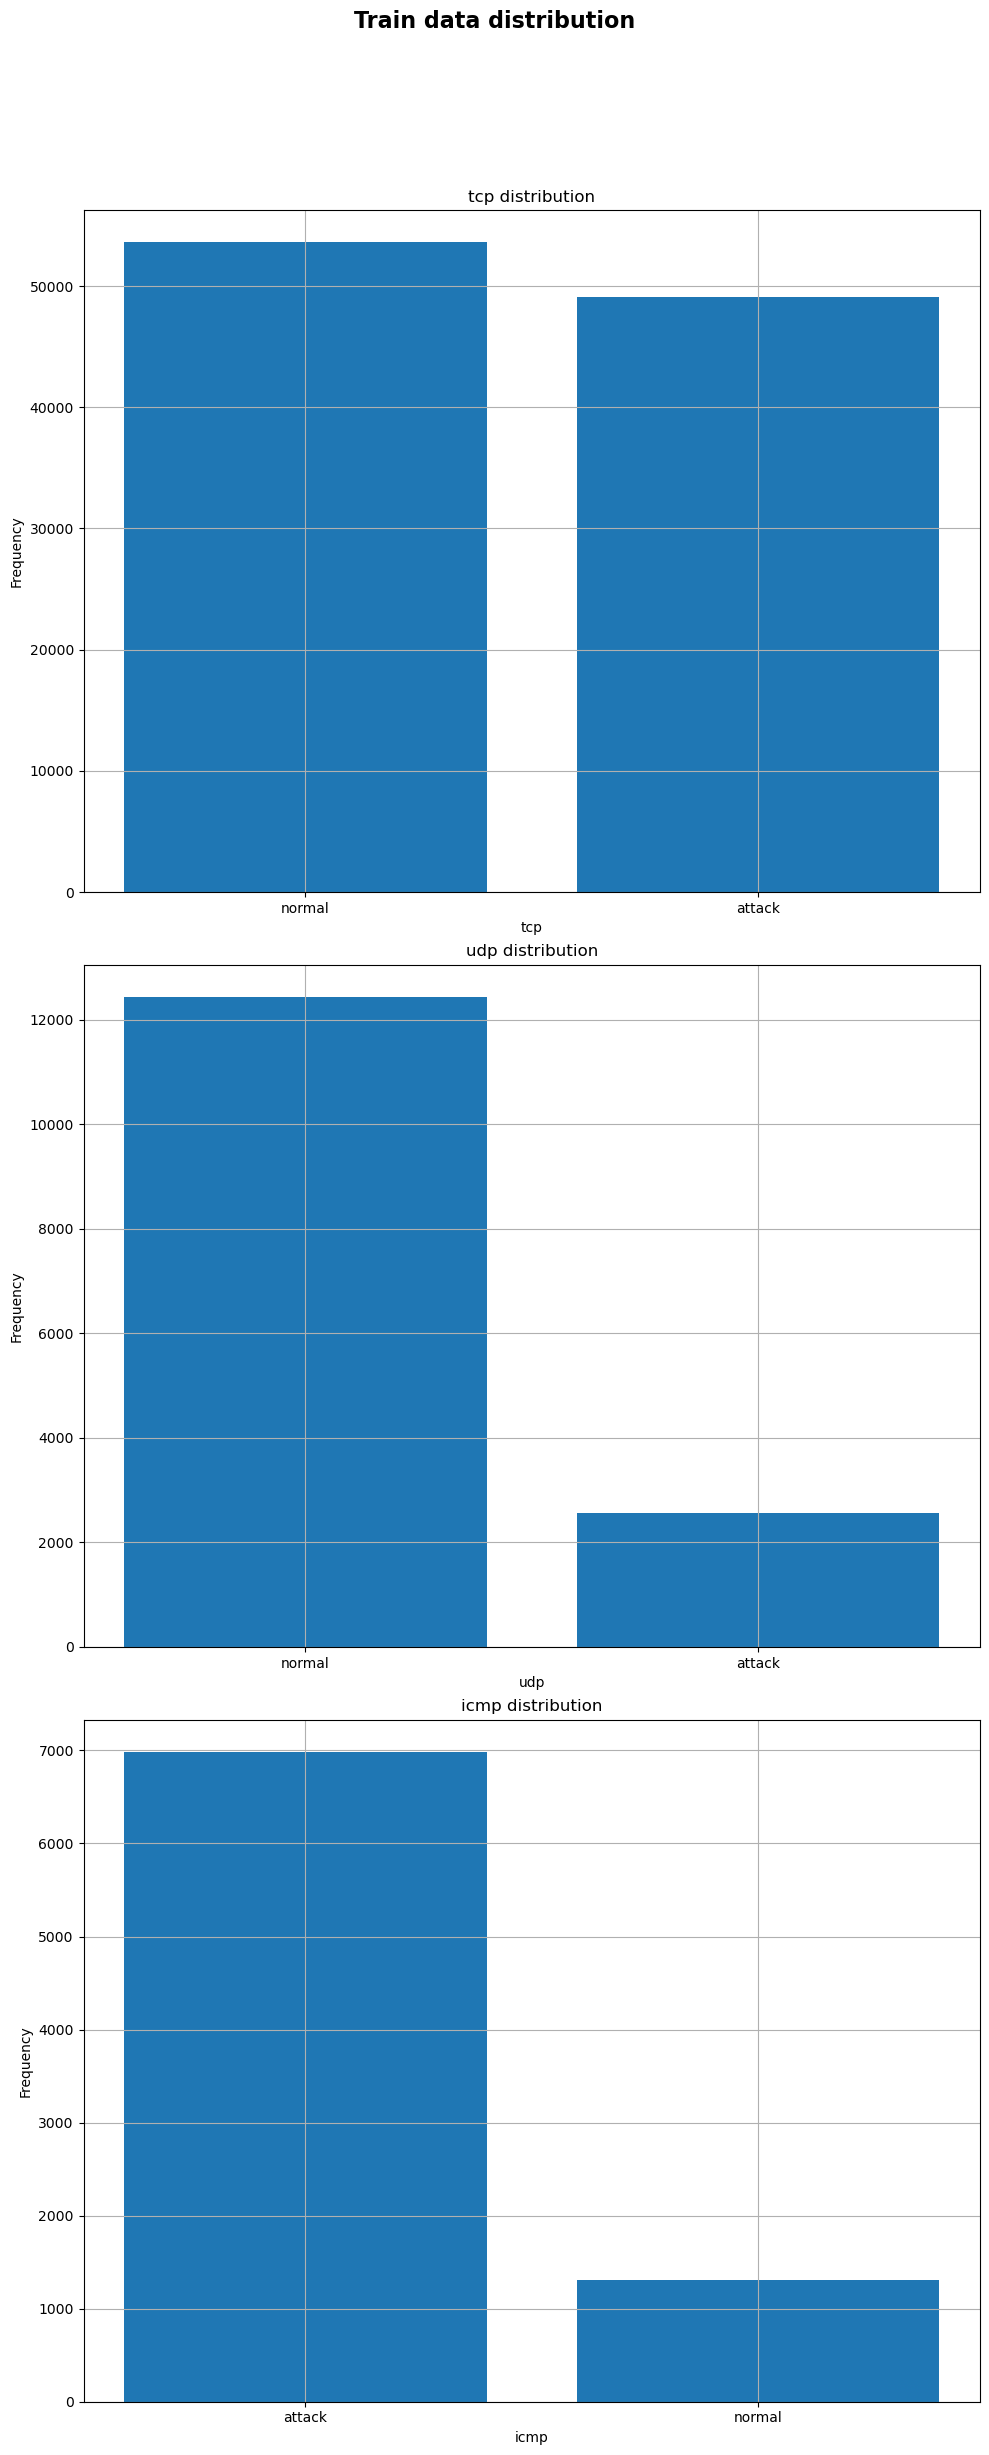

In [15]:
# Plot train data
bar_plots(get_distribution(data_train, "connection_type"), "Train")

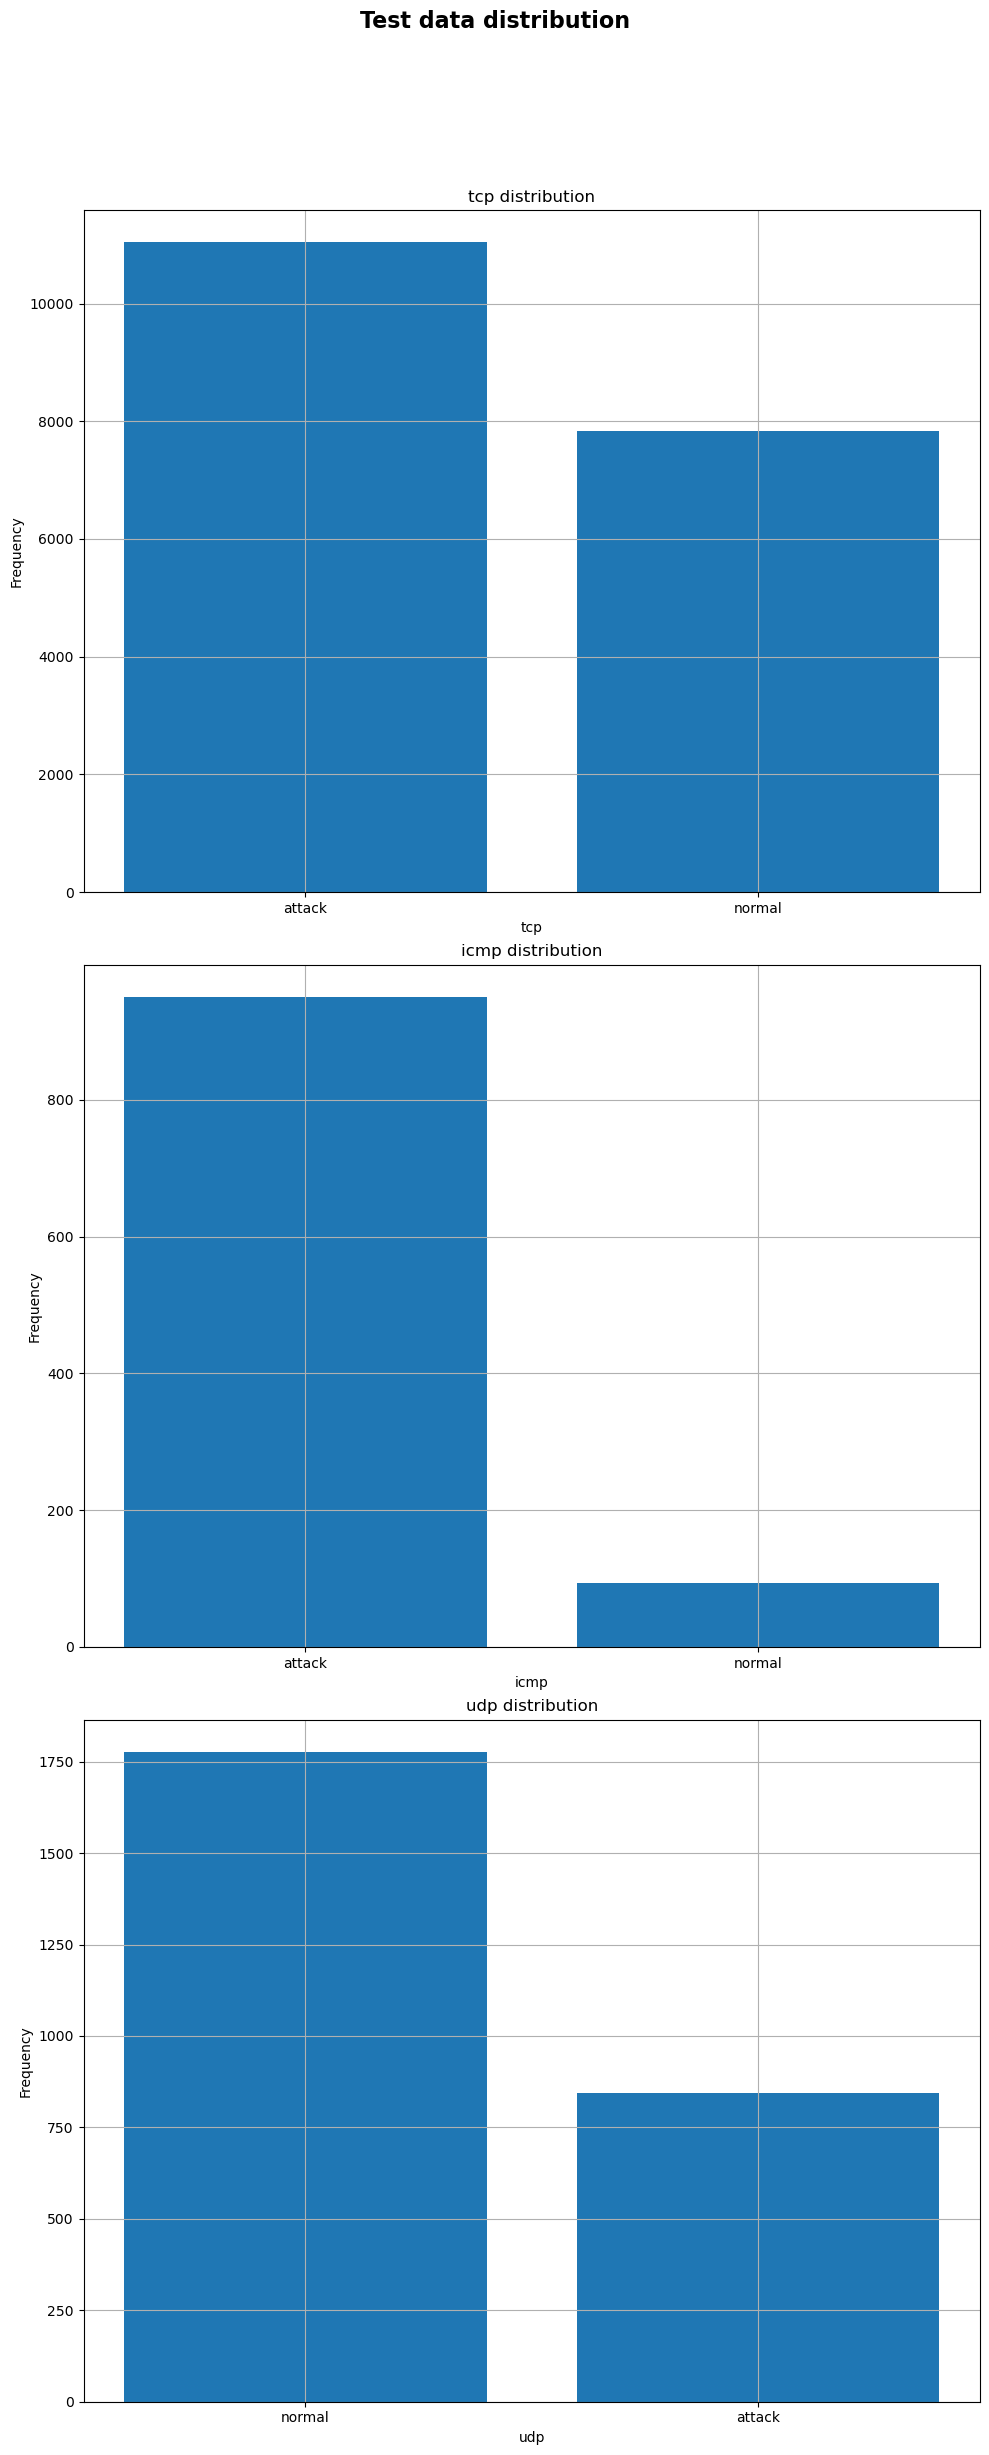

In [16]:
# Plot test data
bar_plots(get_distribution(data_test, "connection_type"), "Test")

### 2.2.2 Attack type distribution per network protocol

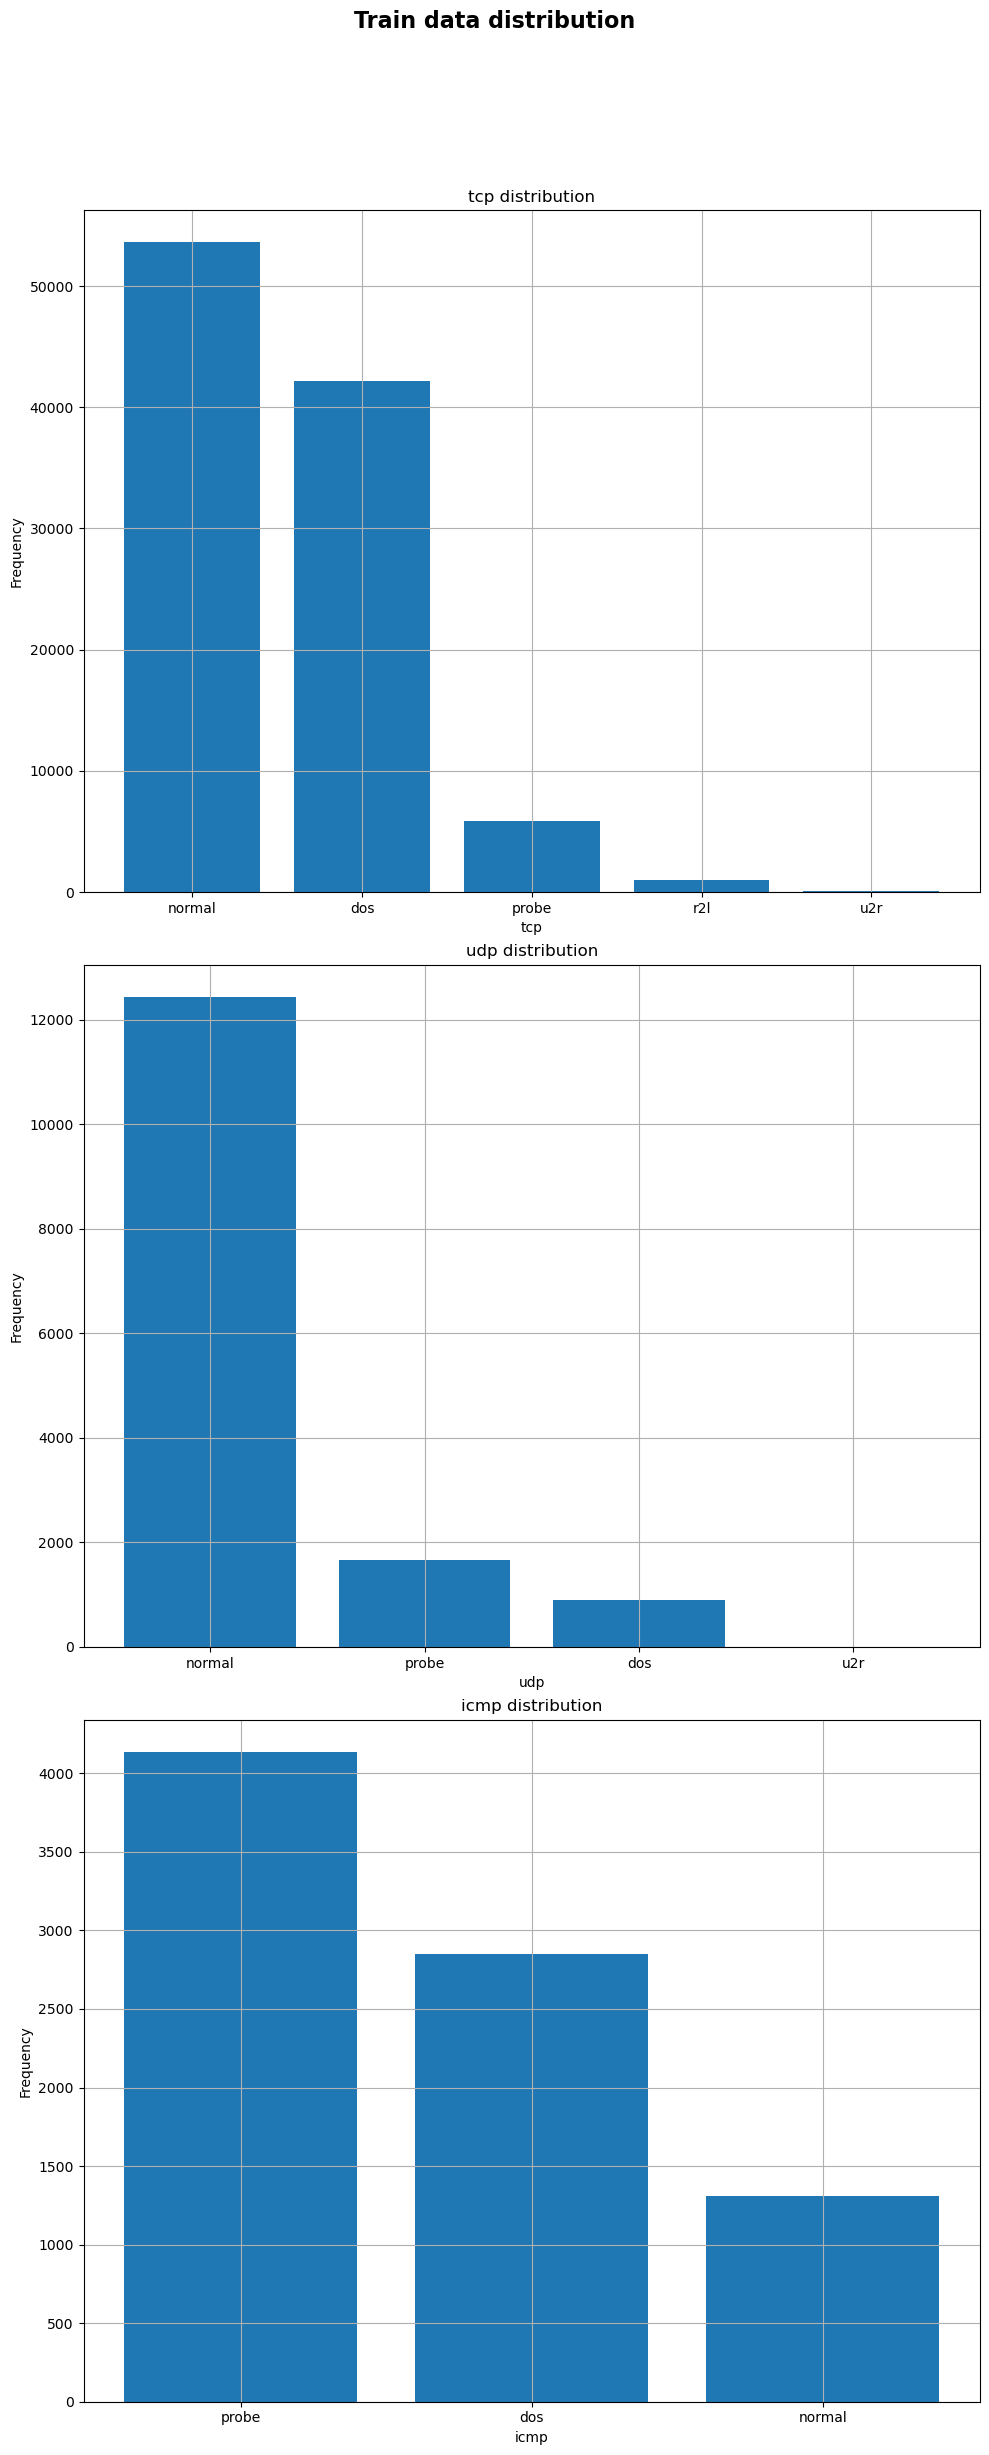

In [17]:
# Plot train data
bar_plots(get_distribution(data_train, "attack_type"), "Train")

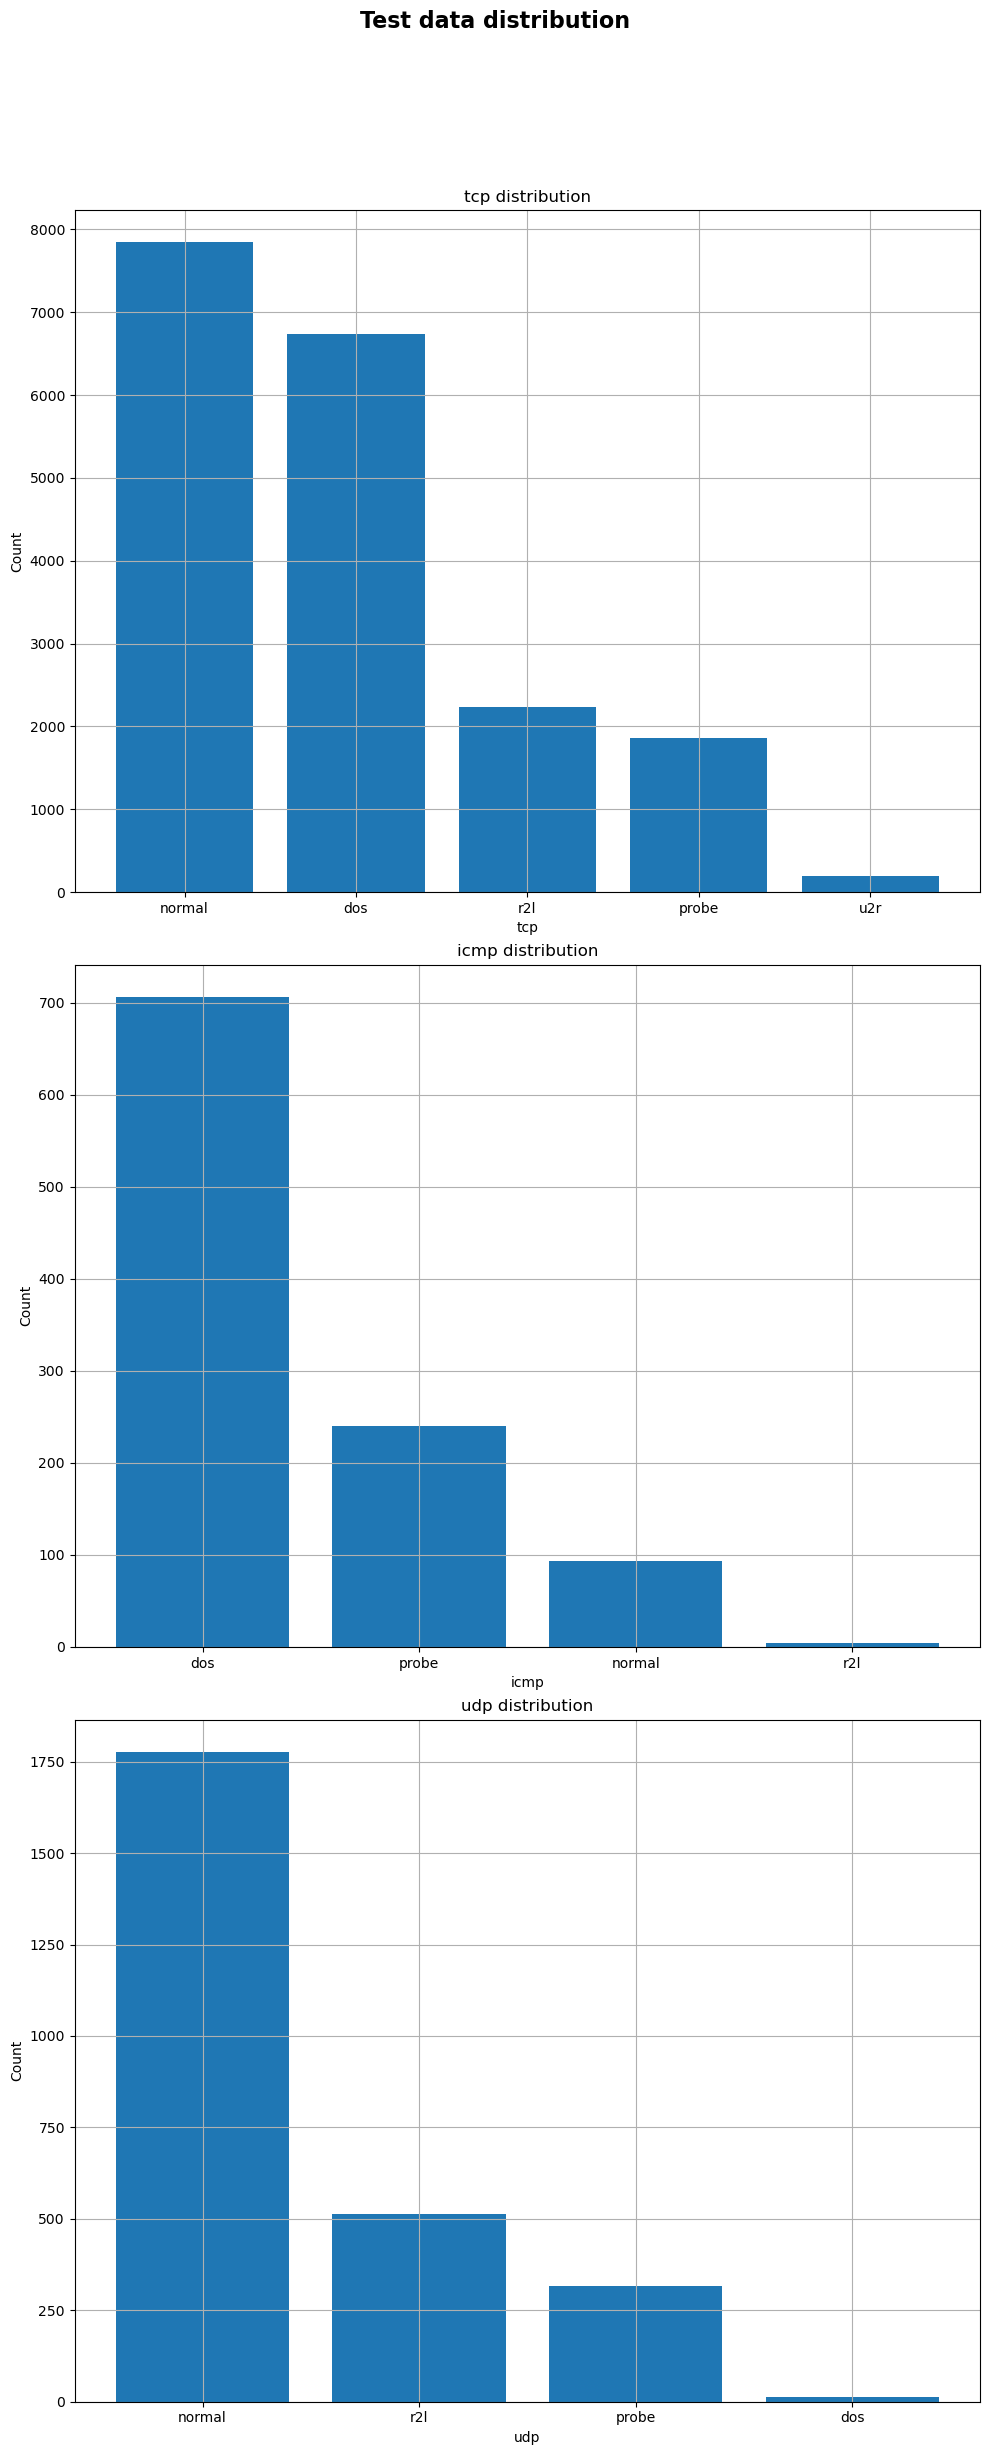

In [40]:
# Plot test data
bar_plots(get_distribution(data_test, "attack_type"), "Test")

### 2.2.3 Class distribution per network protocol

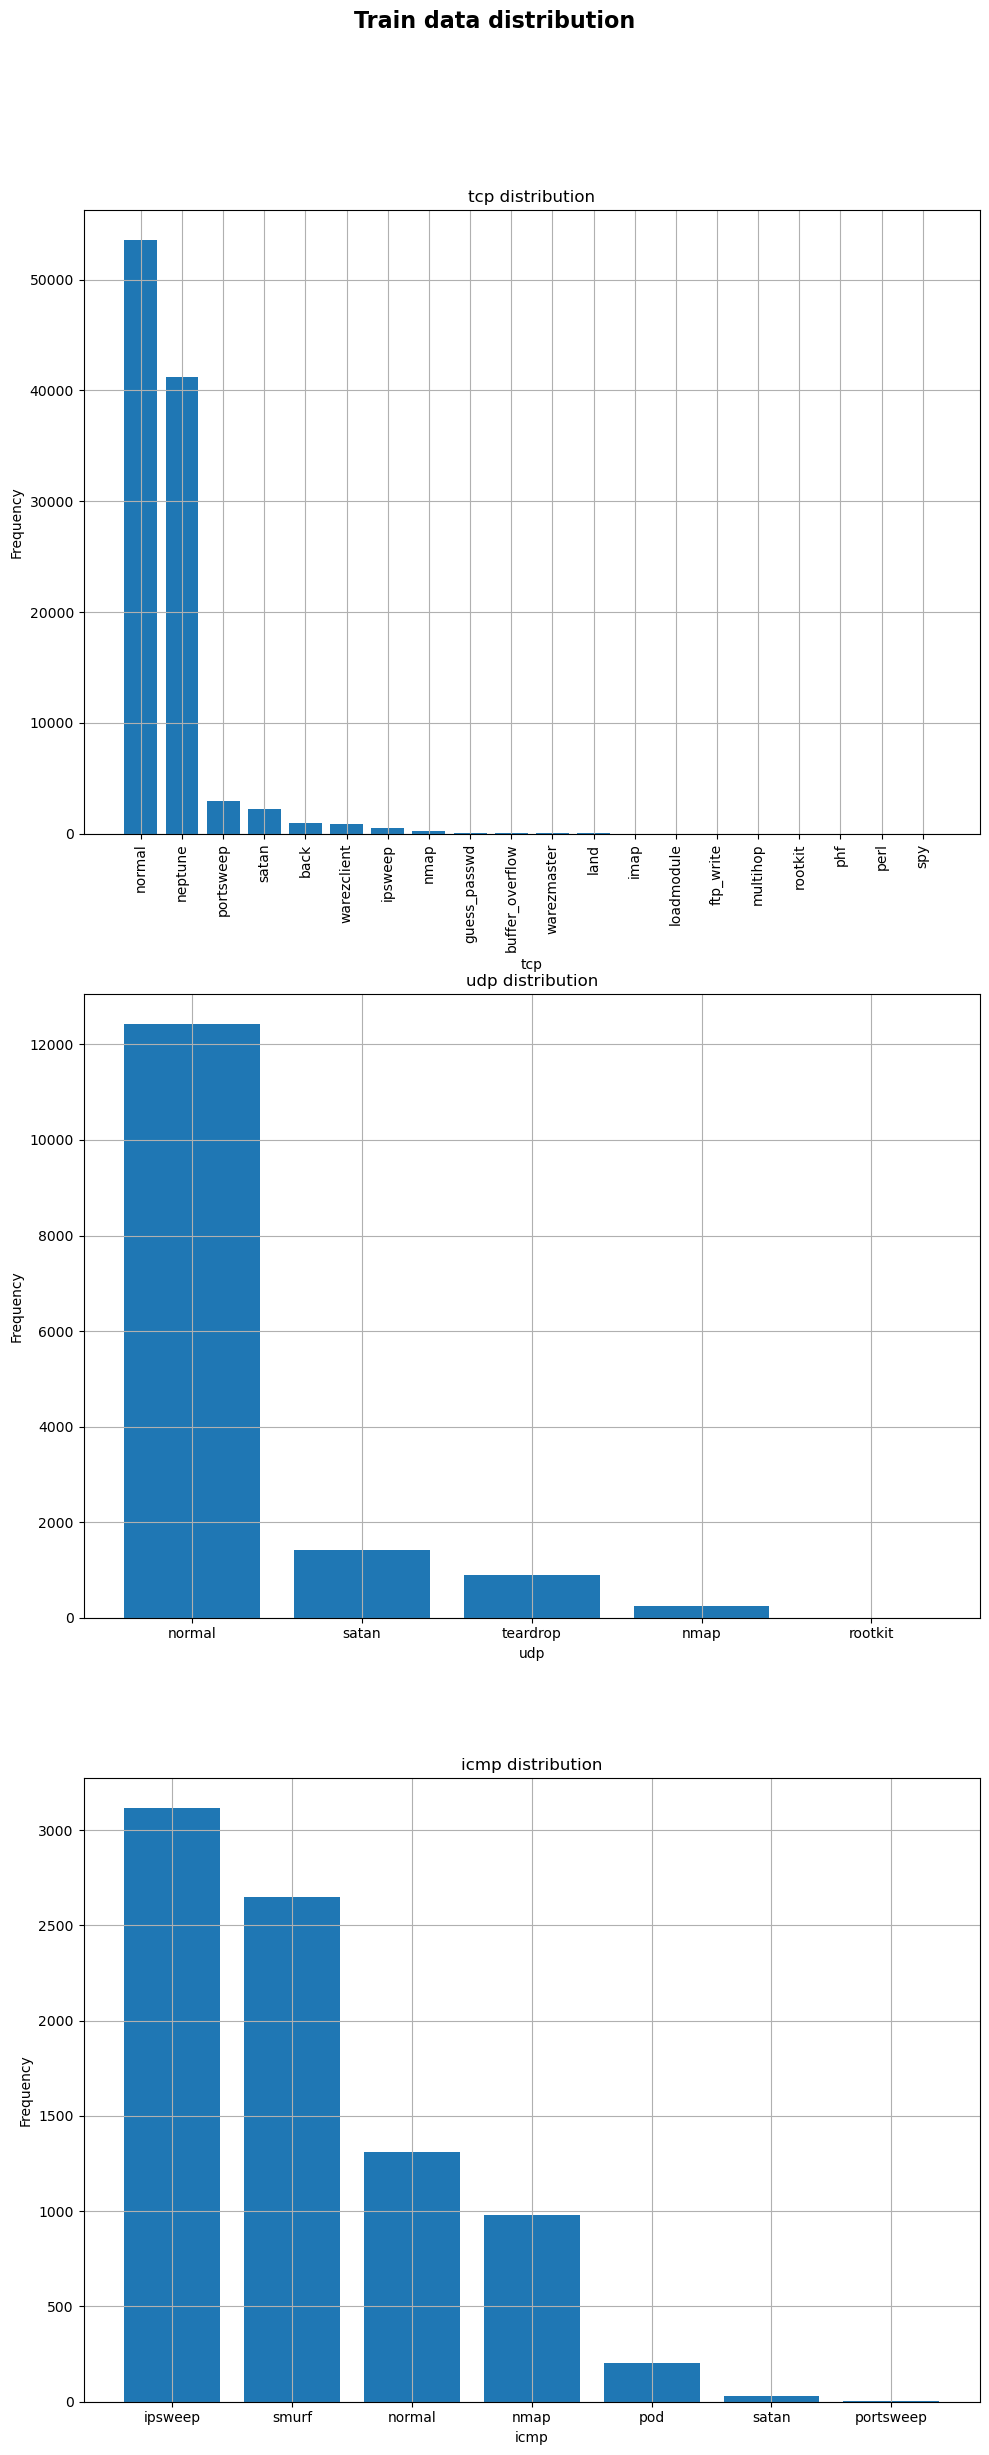

In [18]:
# Plot train data
bar_plots(get_distribution(data_train, "class"), "Train")

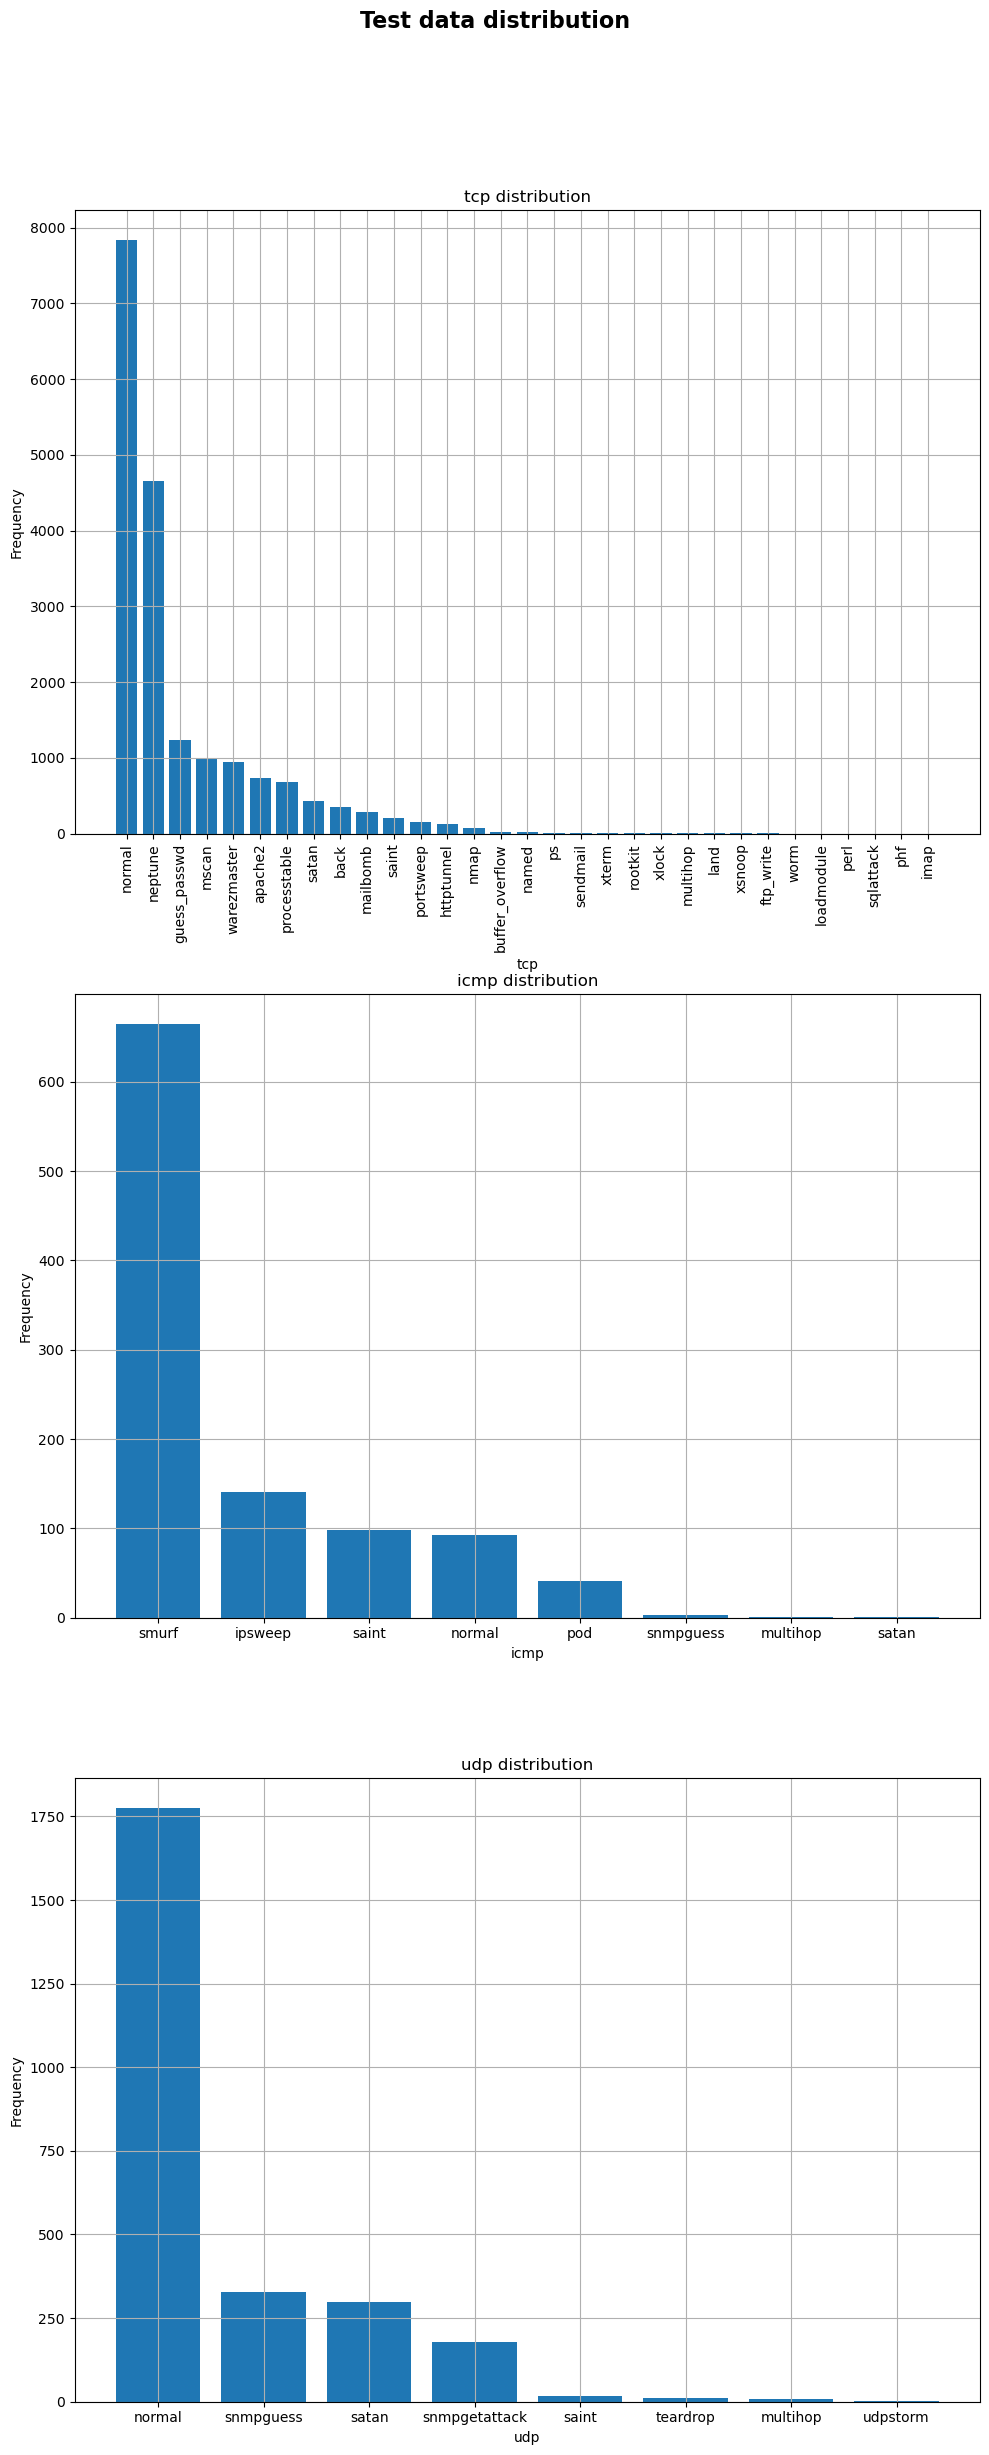

In [19]:
# Plot test data
bar_plots(get_distribution(data_test, "class"), "Test")

## 2.3 Pie charts

In [13]:
# Draw pie plots of continuous data statistics
def pie_plots(df, title):
    columns = ['protocol_type', 'attack_type', 'connection_type']
    columns_count = len(columns)
    fig, ax = plt.subplots(nrows=columns_count,
                           ncols=1,
                           figsize=(10,10))
    for i in range(columns_count):
        _dict = df[columns[i]].value_counts().to_dict()
        ax[i].pie(_dict.values())
        ax[i].set(title=f"{columns[i]} distribution")
        ax[i].legend(loc="upper right", labels=_dict.keys(), bbox_to_anchor=(1.55,0.75), title=f"{columns[i]}")
    fig.suptitle(f"{title} data distribution", fontsize=16, fontweight="bold")

### 2.3.1 Train data distribution

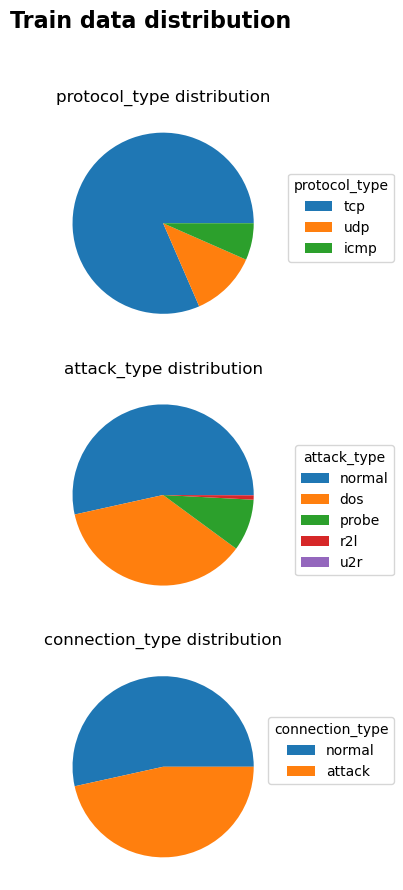

In [21]:
pie_plots(data_train, "Train")

### 2.3.2 Test data distribution

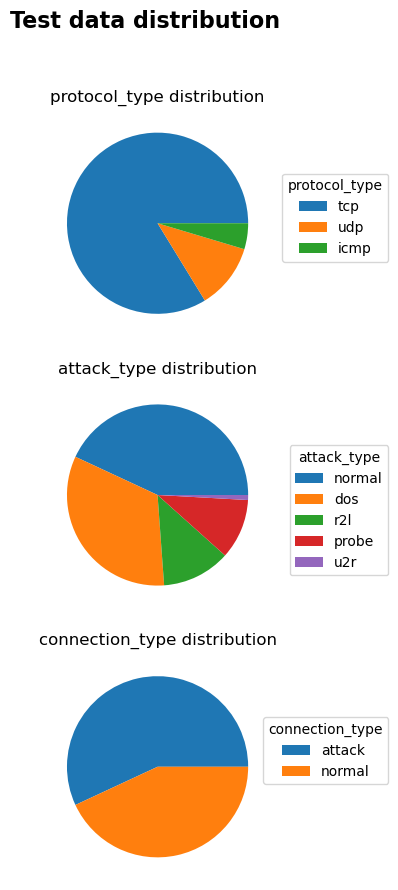

In [22]:
pie_plots(data_test, "Test")

## 2.4 Drawing a heatmap

In [14]:
def correlation(df):
    df = df.select_dtypes(exclude=['object']) # Drop NaN columns
    df = df[[col for col in df if df[col].nunique() > 1]] # Keep columns with more than 1 unique values
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(15,12))
    ax = sns.heatmap(corr)
    plt.show()

### 2.4.1 Train data heatmap

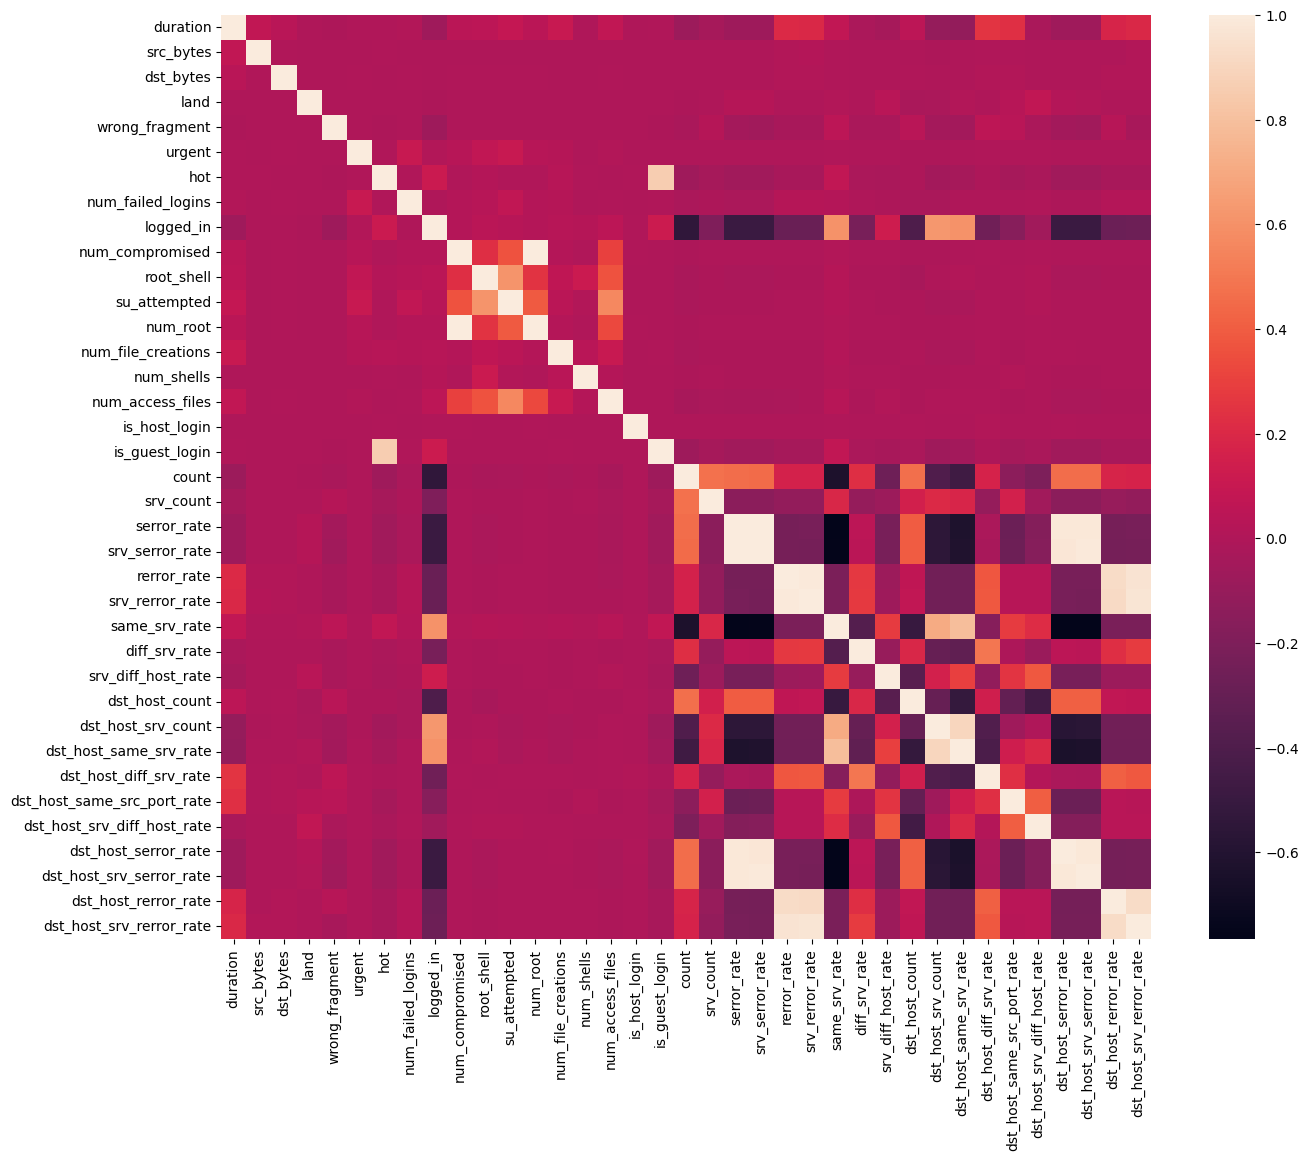

In [29]:
correlation(data_train)

### 2.4.2 Test data heatmap

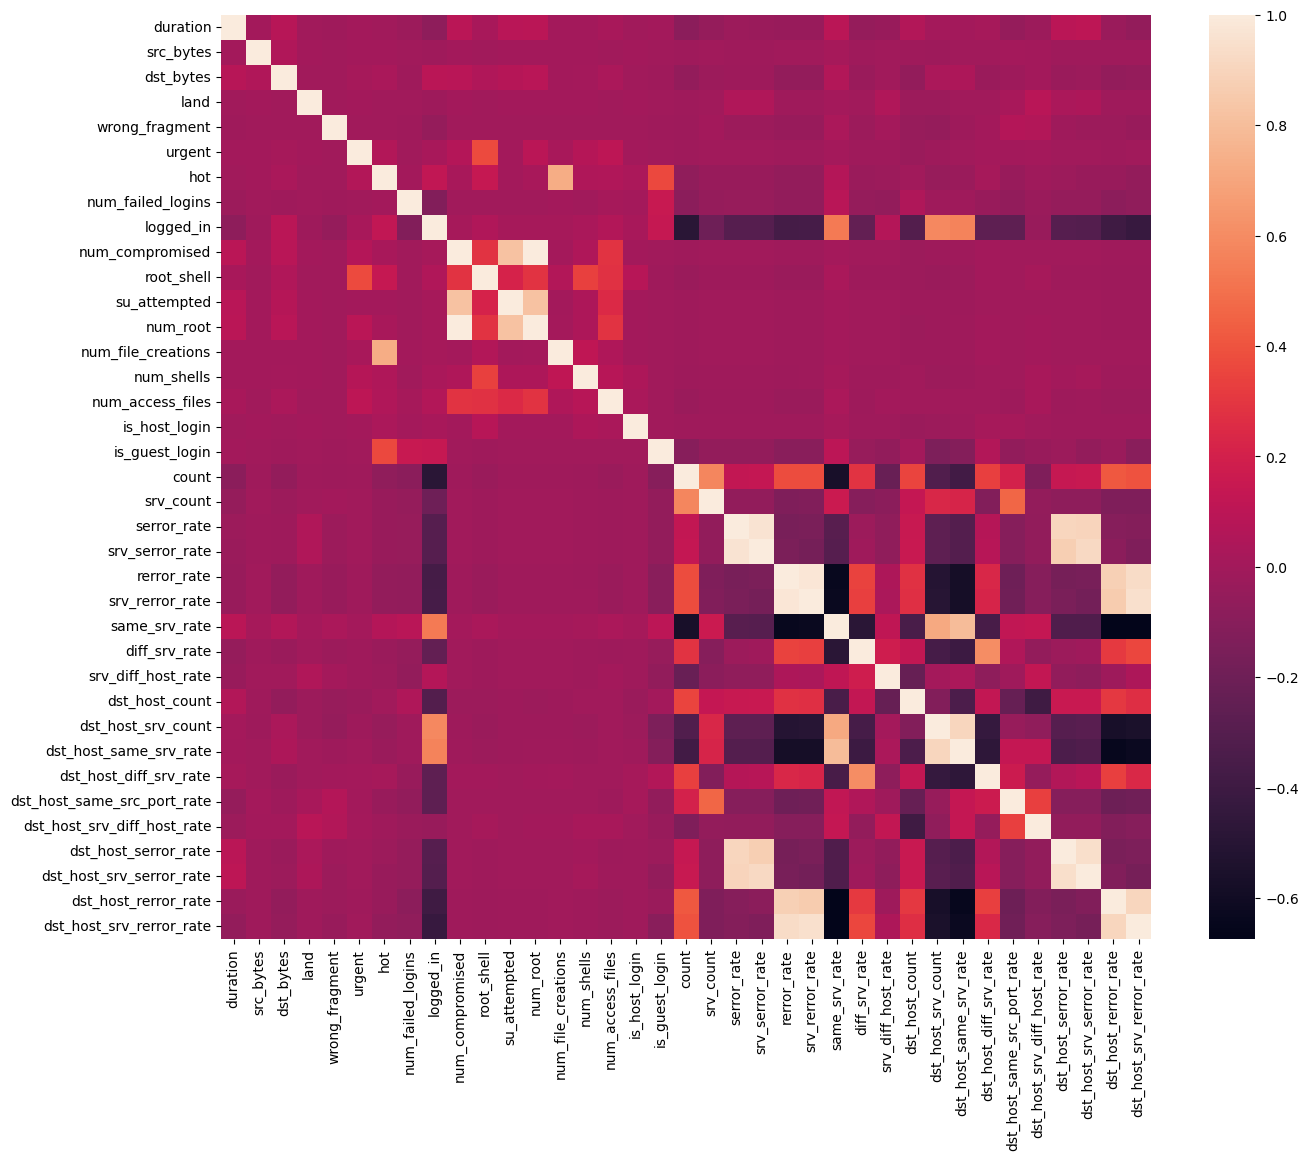

In [30]:
correlation(data_test)

# 3. Data preprocessing

In [15]:
data_train = data_train.drop(['class', 'connection_type'], axis=1)
data_test = data_test.drop(['class', 'connection_type'], axis=1)

In [16]:
data_train.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,dos
6,0,tcp,private,S0,0,0,0,0,0,0,...,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos
7,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,dos
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos
9,0,tcp,private,S0,0,0,0,0,0,0,...,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,dos


In [17]:
data_test.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.00,0.00,1.00,1.00,dos
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.00,0.00,1.00,1.00,dos
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.00,0.00,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.00,0.00,0.00,0.00,probe
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.00,0.00,0.83,0.71,probe
5,0,tcp,http,SF,267,14515,0,0,0,0,...,255,1.00,0.00,0.01,0.03,0.01,0.00,0.00,0.00,normal
6,0,tcp,smtp,SF,1022,387,0,0,0,0,...,28,0.11,0.72,0.00,0.00,0.00,0.00,0.72,0.04,normal
7,0,tcp,telnet,SF,129,174,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.01,0.01,0.02,0.02,r2l
8,0,tcp,http,SF,327,467,0,0,0,0,...,255,1.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00,normal
9,0,tcp,ftp,SF,26,157,0,0,0,0,...,26,0.50,0.08,0.02,0.00,0.00,0.00,0.00,0.00,r2l


In [18]:
def encoding(df):
    columns = df.select_dtypes('object').columns.to_list()
    for column in columns:
        uniq = df[column].unique().tolist()
        _dict = {}
        for i in range(len(uniq)):
            _dict[uniq[i]] = i
        df[column] = df[column].map(_dict)
    return df

In [19]:
data_train = encoding(data_train)
data_test = encoding(data_test)

In [20]:
data_train.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,0,0,0,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,1,1,0,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,0,2,1,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,0,3,0,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,0,3,0,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
5,0,0,2,2,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,1
6,0,0,2,1,0,0,0,0,0,0,...,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
7,0,0,2,1,0,0,0,0,0,0,...,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,1
8,0,0,4,1,0,0,0,0,0,0,...,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
9,0,0,2,1,0,0,0,0,0,0,...,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,1


In [25]:
data_test.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,0,0,0,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.00,0.00,1.00,1.00,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.00,0.00,1.00,1.00,0
2,2,0,1,1,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.00,0.00,0.00,0.00,1
3,0,1,2,1,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.00,0.00,0.00,0.00,2
4,1,0,3,2,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.00,0.00,0.83,0.71,2
5,0,0,4,1,267,14515,0,0,0,0,...,255,1.00,0.00,0.01,0.03,0.01,0.00,0.00,0.00,1
6,0,0,5,1,1022,387,0,0,0,0,...,28,0.11,0.72,0.00,0.00,0.00,0.00,0.72,0.04,1
7,0,0,3,1,129,174,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.01,0.01,0.02,0.02,3
8,0,0,4,1,327,467,0,0,0,0,...,255,1.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00,1
9,0,0,6,1,26,157,0,0,0,0,...,26,0.50,0.08,0.02,0.00,0.00,0.00,0.00,0.00,3


In [2]:
def normalize(df, scaler):
    data = df[df.columns[:41]]
    data = scaler.fit_transform(data)
    data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
    labels = df[df.columns[-1]]
    return data, labels

In [3]:
train_data, train_labels = normalize(data_train, MinMaxScaler())

NameError: name 'data_train' is not defined

In [4]:
test_data, test_labels = normalize(data_test, MinMaxScaler())

NameError: name 'data_test' is not defined